In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [2]:
reldir = '../msd.recsys/datasets/'

In [3]:
def get_user_taste_data(filename):
    tasteDF = pd.read_csv(filename, sep='\t', header=None, names=['user','song','count'])
    return tasteDF

In [4]:
df_user_t = get_user_taste_data(reldir + 'train_triplets.txt')

In [5]:
df_user = df_user_t.iloc[:1_000_000, :]

To build the preprocessing model, start by building a set of symbolic `keras.Input` objects, matching the names and data-types of the CSV columns.

In [6]:
inputs = {}

for name, column in df_user.items():
    dtype = column.dtype
    if ( dtype == object ):
        dtype = tf.string
    else :
        dtype = tf.float32
    
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [7]:
inputs

{'user': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'user')>,
 'song': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'song')>,
 'count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'count')>}

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [8]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(df_user[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [9]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `preprocessing.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `preprocessing.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model.

The default settings for the `preprocessing.CategoryEncoding` layer create a one-hot vector for each input. A `layers.Embedding` would also work.

In [10]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(df_user[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [11]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

user_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

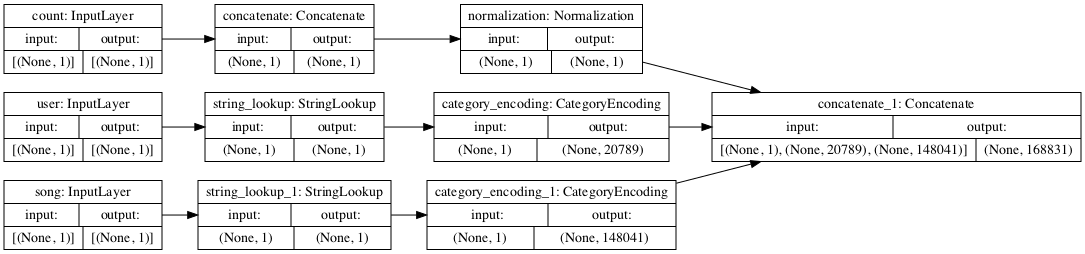

In [12]:
tf.keras.utils.plot_model(model = user_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [13]:
df_user_dict = {name : np.array(value) for name, value in df_user.items()}

In [14]:
df_user_dict

{'user': array(['b80344d063b5ccb3212f76538f3d9e43d87dca9e',
        'b80344d063b5ccb3212f76538f3d9e43d87dca9e',
        'b80344d063b5ccb3212f76538f3d9e43d87dca9e', ...,
        'd09bc76299e5922b38e4e9fd9ecfcc7023128d39',
        'd09bc76299e5922b38e4e9fd9ecfcc7023128d39',
        'd09bc76299e5922b38e4e9fd9ecfcc7023128d39'], dtype=object),
 'song': array(['SOAKIMP12A8C130995', 'SOAPDEY12A81C210A9', 'SOBBMDR12A8C13253B',
        ..., 'SOYIOZB12A58A797FC', 'SOYJHWK12AB01894C4',
        'SOYMIMI12AB0181E5C'], dtype=object),
 'count': array([1, 1, 2, ..., 2, 1, 6])}

In [17]:
def user_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])
    
    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)
    
    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.optimizers.Adam())
    return model

In [18]:
user_model = user_model(user_preprocessing, inputs)